# Satellite classification via fine-tuning with VGG16

**Author:** [Praveen Manikonda]
**Description:** Use VGG16 with weights pre-trained on imagenet for Satellite classification.

# VGG16 Model 
We use VGG16 pretrained model. VGG-16 is a trained Convolutional Neural Network (CNN), from Visual Geometry Group (VGG), Department of Engineering Science, University of Oxford. The number 16 means the number of layers with trainable weights. The reference paper is here:

https://arxiv.org/abs/1409.1556

A review article is here:

https://neurohive.io/en/popular-networks/vgg16/

First, we retain all the base and remove only the dense top layer and train the model. Which gives us validation accuracy close to 80%. And in second step, we unlock the top convolutional model on the base and further train the model. Since we already have a decent accuracy we can imagine that the model is already close to the optimum model. So we only need to fine tune. For this reason we drop the learning rate to 10% of the previous case and train for larger number of iterations. Doing so we achieve a training accuracy > 90%. Which is pretty decent result.



## Setup and data loading

This example requires TensorFlow 2.3 or above.

To use TPU, the TPU runtime must match current running TensorFlow
version. If there is a mismatch, try:

```python
from cloud_tpu_client import Client
c = Client()
c.configure_tpu_version(tf.__version__, restart_type="always")
```

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
    print("Running on TPU ", tpu.cluster_spec().as_dict()["worker"])
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError:
    print("Not connected to a TPU runtime. Using CPU/GPU strategy")
    strategy = tf.distribute.MirroredStrategy()


2.4.1
Not connected to a TPU runtime. Using CPU/GPU strategy
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


In [ ]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
from tensorflow.keras.applications import VGG16                         # pretrained CNN                        
from tensorflow.keras.callbacks import ModelCheckpoint                  # furter train the saved model 
from tensorflow.keras import models, layers, optimizers                 # building DNN is keras 
from tensorflow.keras.models import load_model               # load saved model 
# from tensorflow.keras.preprocessing.image import ImageDataGenerator     # preparing image data for training 

### Data Collection

We've collected all the data and split them into train, test and validation using 70,15,15 percentages and kept them under folders of fire and nofire for the positive and negative examples of images having fire and no fire. 

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
NUM_CLASSES=2

In [ ]:
# One-hot / categorical encoding
def input_preprocess(image, label):
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label


base_dir = os.path.join(os.path.dirname('/content/gdrive/My Drive/'), 'satellite_images')
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')
print(train_dir)
train_fire_dir = os.path.join(train_dir, 'fire')  # directory with fire pictures
print(train_fire_dir)
train_nofire_dir = os.path.join(train_dir, 'nofire')  # directory with no-fire pictures
validation_fire_dir = os.path.join(validation_dir, 'fire')  # directory with ofire pictures
validation_nofire_dir = os.path.join(validation_dir, 'nofire')  # directory with no-fire pictures
test_fire_dir = os.path.join(test_dir, 'fire')
test_nofire_dir = os.path.join(test_dir, 'nofire')
print(train_nofire_dir)


/content/gdrive/My Drive/satellite_images/train
/content/gdrive/My Drive/satellite_images/train/fire
/content/gdrive/My Drive/satellite_images/train/nofire


In [ ]:
num_fire_tr = len(os.listdir(train_fire_dir))
num_nofire_tr = len(os.listdir(train_nofire_dir))

num_fire_val = len(os.listdir(validation_fire_dir))
num_nofire_val = len(os.listdir(validation_nofire_dir))
num_fire_test = len(os.listdir(test_fire_dir))
num_nofire_test = len(os.listdir(test_nofire_dir))

total_train = num_fire_tr + num_nofire_tr
total_val = num_fire_val + num_nofire_val
total_test = num_fire_test + num_nofire_test

# Data Statistics
In this section we will show basic data stats and some sample training set images. 

In [ ]:
print('total training fire images:', num_fire_tr)
print('total training nofire images:', num_nofire_tr)

print('total validation fire images:', num_fire_val)
print('total validation nofire images:', num_nofire_val)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)
print("Total Test Images:", total_test)

total training fire images: 72
total training nofire images: 59
total validation fire images: 19
total validation nofire images: 24
--
Total training images: 131
Total validation images: 43
Total Test Images: 61


In [ ]:
BATCH_SIZE = 100 # Number of training examples to process before updating our models variables
IMG_SHAPE  = 100  # Our training data consists of images with width of 150 pixels and height of 150 pixels

In [ ]:
train_image_generator      = ImageDataGenerator(rescale=1./255)  # Generator for our training data
validation_image_generator = ImageDataGenerator(rescale=1./255)  # Generator for our validation data
test_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our test data

In [ ]:
image_gen_train = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=45,
                    width_shift_range=.15,
                    height_shift_range=.15,
                    horizontal_flip=True,
                    zoom_range=0.5
                    )


train_data_gen = image_gen_train.flow_from_directory(batch_size=BATCH_SIZE,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_SHAPE,IMG_SHAPE), 
                                                           class_mode='binary')

Found 131 images belonging to 2 classes.


In [ ]:
val_data_gen = validation_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                              directory=validation_dir,
                                                              shuffle=False,
                                                              target_size=(IMG_SHAPE,IMG_SHAPE),
                                                              class_mode='binary')

Found 42 images belonging to 2 classes.


In [ ]:
test_data_gen = image_gen_train.flow_from_directory(batch_size=BATCH_SIZE,
                                                           directory=test_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_SHAPE,IMG_SHAPE), 
                                                           class_mode='binary')

Found 60 images belonging to 2 classes.


In [ ]:
sample_training_images, _ = next(train_data_gen)

In [ ]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

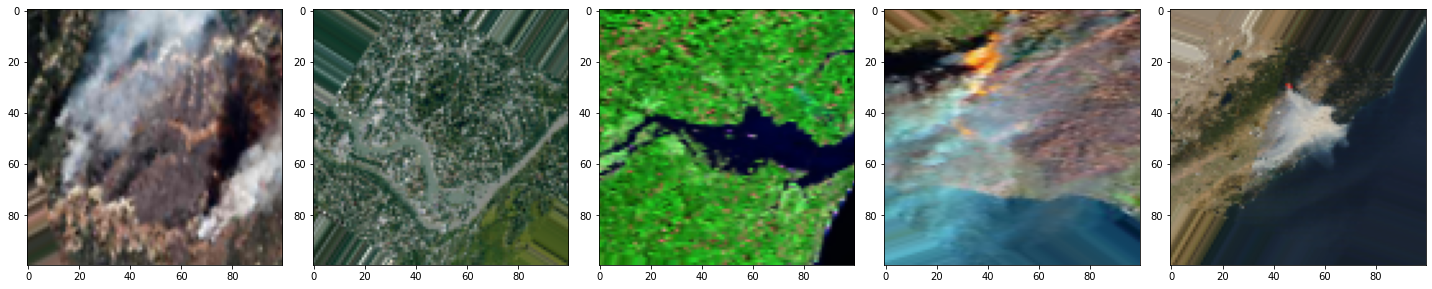

In [ ]:
plotImages(sample_training_images[0:10])  

#### Setting up model 

We set the model with VGG16 base and custom top. 

- Loss: Since this is classification problem and there are two classes, we use the binary cross-entropy as the loss function. 

- Optimizer: We use RMSprop optimizer with customized learning rate. 

- Metrics: In addition to the loss we want to observe the accuracy. We optimize our model based on this metric.

In [ ]:
conv_base = VGG16(weights='imagenet', 
                 include_top=False,
                 input_shape=(100, 100, 3))

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

conv_base.trainable = False

model.compile(loss='binary_crossentropy', 
             optimizer=optimizers.RMSprop(lr=1e-4), 
             metrics=['acc'])

58892288/58889256 [==============================] - 1s 0us/step


Here is the summary of the model. 

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 3, 3, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 4608)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               1179904   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 15,894,849
Trainable params: 1,180,161
Non-trainable params: 14,714,688
_________________________________________________________________


### Training VGG Model

We pass the training data from the train_generator. We train for 30 epochs. We pass the validation data from the validation_generator.  We get validation accuracy above to 90% from this. 

In [ ]:
history = model.fit(train_data_gen, epochs=30, 
                    validation_data=val_data_gen, verbose=2)

Epoch 1/30
2/2 - 48s - loss: 0.6933 - acc: 0.5802 - val_loss: 0.6312 - val_acc: 0.5714
Epoch 2/30
2/2 - 29s - loss: 0.7377 - acc: 0.4885 - val_loss: 0.5437 - val_acc: 0.7857
Epoch 3/30
2/2 - 29s - loss: 0.5544 - acc: 0.8092 - val_loss: 0.7497 - val_acc: 0.5476
Epoch 4/30
2/2 - 30s - loss: 0.5759 - acc: 0.6260 - val_loss: 0.4986 - val_acc: 0.8571
Epoch 5/30
2/2 - 29s - loss: 0.5189 - acc: 0.7863 - val_loss: 0.4886 - val_acc: 0.7857
Epoch 6/30
2/2 - 29s - loss: 0.4865 - acc: 0.8168 - val_loss: 0.5641 - val_acc: 0.6190
Epoch 7/30
2/2 - 29s - loss: 0.4777 - acc: 0.7939 - val_loss: 0.4711 - val_acc: 0.8095
Epoch 8/30
2/2 - 30s - loss: 0.4339 - acc: 0.8702 - val_loss: 0.4418 - val_acc: 0.8571
Epoch 9/30
2/2 - 30s - loss: 0.4462 - acc: 0.8015 - val_loss: 0.4299 - val_acc: 0.8333
Epoch 10/30
2/2 - 31s - loss: 0.4019 - acc: 0.8779 - val_loss: 0.4561 - val_acc: 0.8095
Epoch 11/30
2/2 - 33s - loss: 0.3917 - acc: 0.8626 - val_loss: 0.4810 - val_acc: 0.7143
Epoch 12/30
2/2 - 30s - loss: 0.3791 - ac

Saving the model for the future use. 

In [ ]:
model.save('VGG16_lr-4.h5')

#### Visualization of the learning 

Training gives four sets of values in each eopch

- Training accuracy 
- Validation accuracy 
- Training loss 
- Validation loss 

In [ ]:
# Dictionary to extract the numbers 
hist_dict = history.history

# Training and validation accuracy 
training_acc = hist_dict['acc']
validation_acc = hist_dict['val_acc']

# Training and validation loss 
training_loss = hist_dict['loss']
validation_loss = hist_dict['val_loss']

# Number of epochs 
epoches = range(1, 1 + len(training_acc))

In [ ]:
def plot_func(entity):
    
    '''
    This function produces plot to compare the performance 
    between train set and validation set. 
    entity can be loss of accuracy. 
    '''
    
    plt.figure(figsize=(8, 5))
    plt.plot(epoches, eval('training_' + entity), 'r')
    plt.plot(epoches, eval('validation_' + entity), 'b')
    plt.legend(['Training ' + entity, 'Validation ' + entity])
    plt.xlabel('Epoches')
    plt.ylabel(entity)
    plt.show()

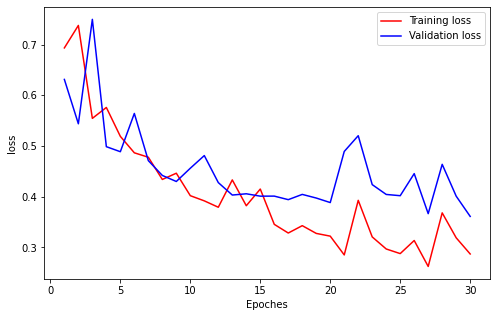

In [ ]:
plot_func('loss')

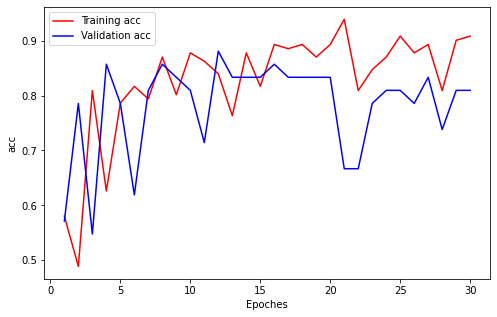

In [ ]:
plot_func('acc')

# Fine tuning the model

#### Unlocking the top convolutional block 

We trained previosuly with only top layer removed from VGG16. Here we unlock top base layer from VGG16 and fine tune the model. Doing so we reduce the learning rate from $10^{-4}$ to $10^{-5}$. We train for the 50 epoches. The model surpass the validation accuracy of 99% shortly after 45 epochs.

In [ ]:
conv_base.trainable = True
set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    else:
        set_trainable = False
    
model.compile(loss='binary_crossentropy', 
             optimizer=optimizers.RMSprop(lr=1e-5), 
             metrics=['acc'])

In [ ]:
# history = model.fit_generator(train_generator, epochs=50, 
                            #  validation_data=test_generator)
history = model.fit(train_data_gen, epochs=50, 
                    validation_data=val_data_gen, verbose=2)

Epoch 1/50
2/2 - 76s - loss: 0.4746 - acc: 0.8244 - val_loss: 0.9767 - val_acc: 0.6429
Epoch 2/50
2/2 - 71s - loss: 0.5974 - acc: 0.7252 - val_loss: 0.3224 - val_acc: 0.8333
Epoch 3/50
2/2 - 69s - loss: 0.2337 - acc: 0.9237 - val_loss: 0.3202 - val_acc: 0.8810
Epoch 4/50
2/2 - 68s - loss: 0.2051 - acc: 0.9466 - val_loss: 0.2980 - val_acc: 0.8810
Epoch 5/50
2/2 - 69s - loss: 0.2137 - acc: 0.9160 - val_loss: 0.4183 - val_acc: 0.8095
Epoch 6/50
2/2 - 67s - loss: 0.1710 - acc: 0.9313 - val_loss: 0.2717 - val_acc: 0.8333
Epoch 7/50
2/2 - 71s - loss: 0.1930 - acc: 0.9466 - val_loss: 0.2884 - val_acc: 0.8571
Epoch 8/50
2/2 - 69s - loss: 0.1401 - acc: 0.9618 - val_loss: 0.2790 - val_acc: 0.8095
Epoch 9/50
2/2 - 67s - loss: 0.1468 - acc: 0.9542 - val_loss: 0.2761 - val_acc: 0.8333
Epoch 10/50
2/2 - 68s - loss: 0.1681 - acc: 0.9389 - val_loss: 0.3214 - val_acc: 0.8571
Epoch 11/50
2/2 - 71s - loss: 0.1412 - acc: 0.9313 - val_loss: 0.3021 - val_acc: 0.8810
Epoch 12/50
2/2 - 68s - loss: 0.1433 - ac

In [ ]:
model.save('VGG16_fine_tuned.h5')

In [ ]:
hist_dict = history.history

training_acc = hist_dict['acc']
validation_acc = hist_dict['val_acc']

training_loss = hist_dict['loss']
validation_loss = hist_dict['val_loss']

epoches = range(1, 1 + len(training_acc))

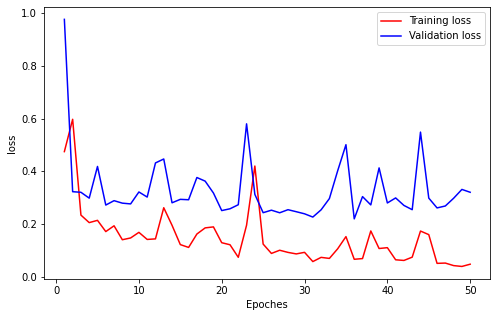

In [ ]:
plot_func('loss')

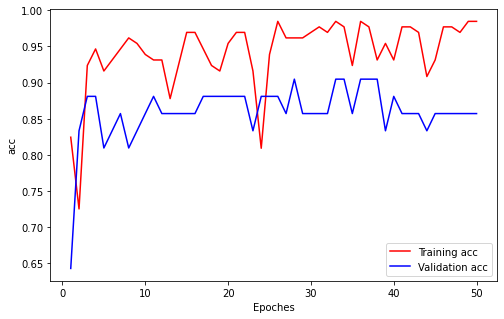

In [ ]:
plot_func('acc')

# Error Analysis

In this section we analyze the error of the model, i.e. mis-classified images. We first see few examples of the correctly classified images. Then we visualize the confusion matrix. And finally, we see separately fire images classified as non-fire and non-fire images classified as fire.  

In [ ]:
# Loading the saved model 
model = load_model('VGG16_fine_tuned.h5')

In [ ]:
# taking first batch from the generator 
img, label = test_data_gen[0] 

# Predicting the images from the first batch 
pred = np.round(model.predict(img)).flatten()

In [ ]:
len(img)

60

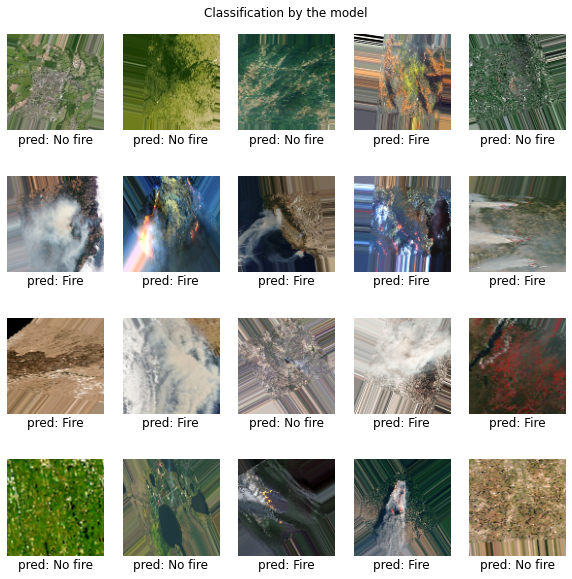

In [ ]:
# Numeric to semantic labels 
label_dict = {1.0: 'No fire', 0.0: 'Fire'}

# Generating collage of plots 
fig = plt.figure(figsize=(10, 10))
plt.title('Classification by the model')
plt.axis('off')

for i, img_i in enumerate(img[:20]):
    ax = fig.add_subplot(4, 5, i+1)
    plt.axis('off')
    plt.title("pred: " + label_dict[pred[i]], y=-0.2)
    ax.imshow(img_i)

In [ ]:
print(len(test_data_gen[0][0]))

60


In [ ]:
# Lists for missed fire images and missed non-fire images
true_fire = []
true_nofire = []
false_fire = []
false_nofire = []

# Iterating through all the batches 
for j in range(1):
    img, label = test_data_gen[j] 
    pred = np.round(model.predict(img)).flatten()
    bool_list = label == pred
    print(pred, label, bool_list)

    # bool_list is False when there is misclassification 
    for i, e in enumerate(bool_list):
        if e == False:
            # separating labels (fire and non-fire)
            if label[i] == 0:
                false_fire.append(img[i])
            else:
                false_nofire.append(img[i])
        else:
            if label[i] == 0:
                true_fire.append(img[i])
            else:
                true_nofire.append(img[i])

[1. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 1. 0. 1. 1.
 0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 0.
 1. 1. 0. 1. 0. 0. 1. 1. 1. 1. 0. 0.] [1. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 1. 1. 0. 1. 1.
 0. 0. 0. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 0.
 1. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0.] [ True  True  True  True  True  True  True  True  True  True False  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True False  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True False False  True  True  True]


#### Confusion Matrix

In [ ]:
print(len(true_fire), len(true_nofire), len(false_fire), len(false_nofire))

25 31 3 1


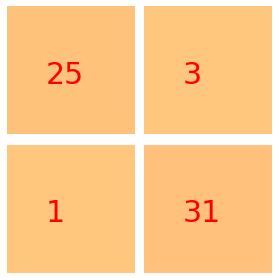

In [ ]:
# confusion matrix (flattened)
conf_mat = [len(true_fire), len(false_fire), len(false_nofire), len(true_nofire)]

# visualization of confusion matrix 
fig = plt.figure(figsize=(4, 4))
for i, j in enumerate(conf_mat):
    ax = fig.add_subplot(2, 2, i+1)
    ax.imshow([[j]], vmin=0, vmax=1000, cmap='copper_r')
    ax.text(-0.2, 0.1, j, c='r', fontsize=30)
    ax.axis('off')

# bringing blocks tighter 
fig.tight_layout()
fig.show()

#### Showing mis-classified fire images 

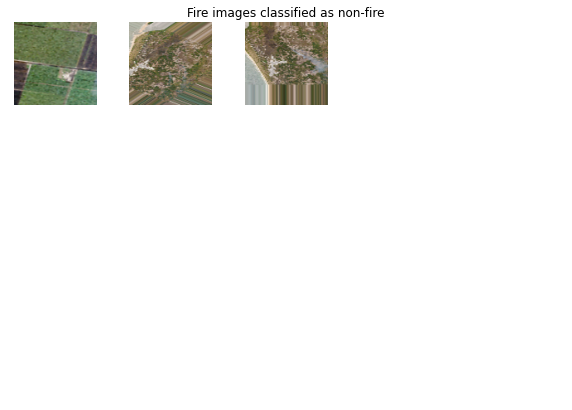

In [ ]:
fig = plt.figure(figsize=(10, 7))
plt.title('Fire images classified as non-fire')
plt.axis('off')
for i, img_i in enumerate(false_fire):        
    ax = fig.add_subplot(4, 5, i+1)
    ax.imshow(img_i)
    ax.axis('off')

#### Showing mis-classified non-fire images.


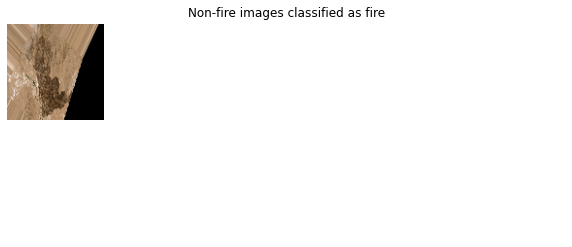

In [ ]:
fig = plt.figure(figsize=(10, 4))
plt.title('Non-fire images classified as fire')
plt.axis('off')
for i, img_i in enumerate(false_nofire):        
    ax = fig.add_subplot(2, 5, i+1)
    ax.imshow(img_i)
    ax.axis('off')

## Test Set Evaluation


In [ ]:
precision = len(true_fire)/(len(true_fire) + len(false_fire))
print("Precision: ", precision)
recall = len(true_fire)/(len(true_fire) + len(false_nofire))
print("Recall: ", recall)
accuracy = (len(true_fire) + len(true_nofire))/(len(true_fire) + len(false_fire) + len(false_nofire) + len(true_nofire))
print("Accuracy: ", accuracy)

Precision:  0.8928571428571429
Recall:  0.9615384615384616
Accuracy:  0.9333333333333333


# Conclusion

VGG16 model architecture produced very accurate models, we were able to get  > 94% accuracy on train and 89% accuracy on validation sets. We only saw a few false positives in on the test set and 92% accuracy on test set.  



# Image Segmentation with Integrated Gradients

Our model is a learned function that describes a mapping between your input feature space, image pixel values, and an output space defined by ImageNet class probability values between 0 and 1. Early interpretability methods for neural networks assigned feature importance scores using gradients, which tell you which pixels have the steepest local relative to your model's prediction at a given point along your model's prediction function. However, gradients only describe *local* changes in your model's prediction function with respect to pixel values and do not fully describe your entire model prediction function. As our model fully "learns" the relationship between the range of an individual pixel and the correct Target class, the gradient for this pixel will *saturate*, meaning become increasingly small and even go to zero. Consider the simple model function below:

In [ ]:
baseline = tf.zeros(shape=(100,100,3))

### Establish a Baseline
A baseline is an input image used as a starting point for calculating feature importance. Intuitively, you can think of the baseline's explanatory role as representing the impact of the absence of each pixel on the "Fireboat" prediction to contrast with its impact of each pixel on the "Fireboat" prediction when present in the input image. As a result, the choice of the baseline plays a central role in interpreting and visualizing pixel feature importances. For additional discussion of baseline selection, see the resources in the "Next steps" section at the bottom of this tutorial. Here, you will use a black image whose pixel values are all zero.

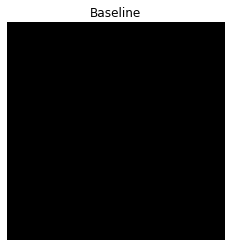

In [ ]:
plt.imshow(baseline)
plt.title("Baseline")
plt.axis('off')
plt.show()

In [ ]:
m_steps=50
alphas = tf.linspace(start=0.0, stop=1.0, num=m_steps+1) # Generate m_steps intervals for integral_approximation() below.

The formula for Integrated Gradients is as follows:

$IntegratedGradients_{i}(x) ::= (x_{i} - x'_{i})\times\int_{\alpha=0}^1\frac{\partial F(x'+\alpha \times (x - x'))}{\partial x_i}{d\alpha}$

where:

$_{i}$ = feature   
$x$ = input  
$x'$ = baseline   
$\alpha$ = interpolation constant to perturb features by

In [ ]:
def interpolate_images(baseline,
                       image,
                       alphas):
  alphas_x = alphas[:, tf.newaxis, tf.newaxis, tf.newaxis]
  baseline_x = tf.expand_dims(baseline, axis=0)
  input_x = tf.expand_dims(image, axis=0)
  delta = input_x - baseline_x
  images = baseline_x +  alphas_x * delta
  return images

In [ ]:
def read_image(file_name):
  image = tf.io.read_file(file_name)
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.convert_image_dtype(image, tf.float32)
  image = tf.image.resize_with_pad(image, target_height=100, target_width=100)
  return image

In [ ]:
test_dir_list = os.listdir(test_fire_dir)
img_name_tensors = []
for f in test_dir_list:
   img_path = test_fire_dir + "/" + f
   print(img_path)
   img_name_tensors.append(read_image(img_path))

/content/gdrive/My Drive/satellite_images/test/fire/sugarcane_burning_florida_s112_20201202T154157Z_rgb_5760_gallery_geo-1-full.jpg
/content/gdrive/My Drive/satellite_images/test/fire/Smoke.jpg
/content/gdrive/My Drive/satellite_images/test/fire/maple-fire-20160821-full.jpg
/content/gdrive/My Drive/satellite_images/test/fire/soberanes-20160804-full.jpg
/content/gdrive/My Drive/satellite_images/test/fire/tullach-mohr-fire-full.jpg
/content/gdrive/My Drive/satellite_images/test/fire/madagascar-brushfire-20151116-full.jpg
/content/gdrive/My Drive/satellite_images/test/fire/madagascar-brushfire-20151115-full.jpg
/content/gdrive/My Drive/satellite_images/test/fire/sabina-fire-full.jpg
/content/gdrive/My Drive/satellite_images/test/fire/campfire_oli_2018312_crop_lrg.jpg
/content/gdrive/My Drive/satellite_images/test/fire/110918-cc-noaa-cal-fires-space-img.jpg
/content/gdrive/My Drive/satellite_images/test/fire/P7WefsES9S9TvSdtuYLe8b-1200-80.jpg
/content/gdrive/My Drive/satellite_images/test/

In [ ]:
interpolated_images = interpolate_images(
    baseline=baseline,
    image=img_name_tensors[2],
    alphas=alphas)

**Let**'s visualize the interpolated images. Note: another way of thinking about the $\alpha$ constant is that it is consistently increasing each interpolated image's intensity.

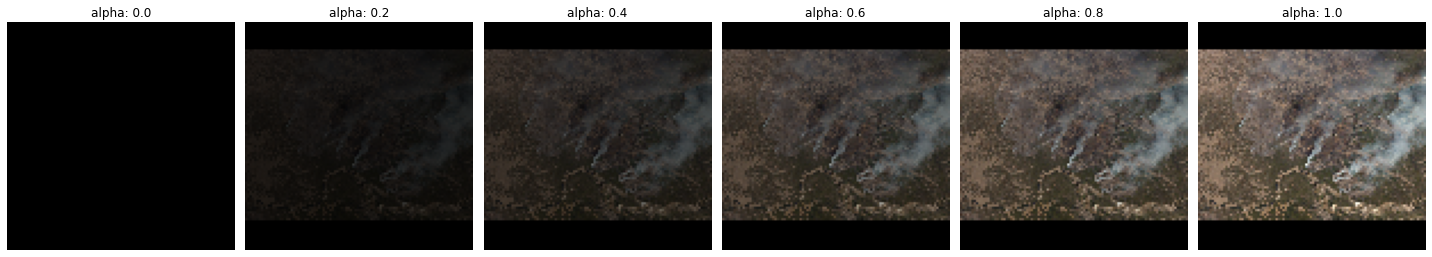

In [ ]:
fig = plt.figure(figsize=(20, 20))

i = 0
for alpha, image in zip(alphas[0::10], interpolated_images[0::10]):
  i += 1
  plt.subplot(1, len(alphas[0::10]), i)
  plt.title(f'alpha: {alpha:.1f}')
  plt.imshow(image)
  plt.axis('off')

plt.tight_layout();

## Compute Gradients
Now let's take a look at how to calculate gradients in order to measure the relationship between changes to a feature and changes in the model's predictions. In the case of images, the gradient tells us which pixels have the strongest effect on the models predicted class probabilities.

In [ ]:
def compute_gradients(images, target_class_idx):
  with tf.GradientTape() as tape:
    tape.watch(images)
    logits = model(images)
    probs = tf.nn.softmax(logits, axis=-1)[:, target_class_idx]
  return tape.gradient(probs, images)

In [ ]:
path_gradients = compute_gradients(
    images=interpolated_images,
    target_class_idx=0)

In [ ]:
print(path_gradients.shape)

(51, 100, 100, 3)


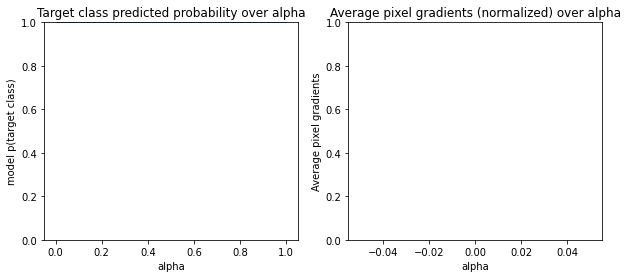

In [ ]:
pred = model(interpolated_images)
pred_proba = tf.nn.softmax(pred, axis=-1)[:, 0]

plt.figure(figsize=(10, 4))
ax1 = plt.subplot(1, 2, 1)
ax1.plot(alphas, pred_proba)
ax1.set_title('Target class predicted probability over alpha')
ax1.set_ylabel('model p(target class)')
ax1.set_xlabel('alpha')
ax1.set_ylim([0, 1])

ax2 = plt.subplot(1, 2, 2)
# Average across interpolation steps
average_grads = tf.reduce_mean(path_gradients, axis=[1, 2, 3])
# Normalize gradients to 0 to 1 scale. E.g. (x - min(x))/(max(x)-min(x))
average_grads_norm = (average_grads-tf.math.reduce_min(average_grads))/(tf.math.reduce_max(average_grads)-tf.reduce_min(average_grads))
ax2.plot(alphas, average_grads_norm)
ax2.set_title('Average pixel gradients (normalized) over alpha')
ax2.set_ylabel('Average pixel gradients')
ax2.set_xlabel('alpha')
ax2.set_ylim([0, 1]);

In [ ]:
def integral_approximation(gradients):
  # riemann_trapezoidal
  grads = (gradients[:-1] + gradients[1:]) / tf.constant(2.0)
  integrated_gradients = tf.math.reduce_mean(grads, axis=0)
  return integrated_gradients

In [ ]:
ig = integral_approximation(
    gradients=path_gradients)

In [ ]:
print(ig.shape)

(100, 100, 3)


## Putting it all together
Now you will combine the 3 previous general parts together into an `IntegratedGradients` function and utilize a [@tf.function](https://www.tensorflow.org/guide/function) decorator to compile it into a high performance callable TensorFlow graph. This is implemented as 5 smaller steps below:

1. Generate alphas $\alpha$

2. Generate interpolated images = $(x' + \frac{k}{m}\times(x - x'))$

3. Compute gradients between model $F$ output predictions with respect to input features = $\frac{\partial F(\text{interpolated path inputs})}{\partial x_{i}}$

4. Integral approximation through averaging gradients = $\sum_{k=1}^m \text{gradients} \times \frac{1}{m}$

5. Scale integrated gradients with respect to original image = $(x_{i}-x'_{i}) \times \text{integrated gradients}$. The reason this step is necessary is to make sure that the attribution values accumulated across multiple interpolated images are in the same units and faithfully represent the pixel importances on the original image.

In [ ]:
@tf.function
def integrated_gradients(baseline,
                         image,
                         target_class_idx,
                         m_steps=50,
                         batch_size=32):
  # 1. Generate alphas.
  alphas = tf.linspace(start=0.0, stop=1.0, num=m_steps+1)

  # Initialize TensorArray outside loop to collect gradients.    
  gradient_batches = tf.TensorArray(tf.float32, size=m_steps+1)
    
  # Iterate alphas range and batch computation for speed, memory efficiency, and scaling to larger m_steps.
  for alpha in tf.range(0, len(alphas), batch_size):
    from_ = alpha
    to = tf.minimum(from_ + batch_size, len(alphas))
    alpha_batch = alphas[from_:to]

    # 2. Generate interpolated inputs between baseline and input.
    interpolated_path_input_batch = interpolate_images(baseline=baseline,
                                                       image=image,
                                                       alphas=alpha_batch)

    # 3. Compute gradients between model outputs and interpolated inputs.
    gradient_batch = compute_gradients(images=interpolated_path_input_batch,
                                       target_class_idx=target_class_idx)
    
    # Write batch indices and gradients to extend TensorArray.
    gradient_batches = gradient_batches.scatter(tf.range(from_, to), gradient_batch)    
  
  # Stack path gradients together row-wise into single tensor.
  total_gradients = gradient_batches.stack()

  # 4. Integral approximation through averaging gradients.
  avg_gradients = integral_approximation(gradients=total_gradients)

  # 5. Scale integrated gradients with respect to input.
  integrated_gradients = (image - baseline) * avg_gradients

  return integrated_gradients

In [ ]:
ig_attributions = integrated_gradients(baseline=baseline,
                                       image=img_name_tensors[0],
                                       target_class_idx=0,
                                       m_steps=240)

In [ ]:
print(ig_attributions.shape)

(100, 100, 3)


### Visualize attributions
You are ready to visualize attributions, and overlay them on the original image. The code below sums the absolute values of the integrated gradients across the color channels to produce an attribution mask. This plotting method captures the relative impact of pixels on the model's predictions. 

In [ ]:
def plot_img_attributions(baseline,
                          image,
                          target_class_idx,
                          m_steps=50,
                          cmap=None,
                          overlay_alpha=0.4):

  attributions = integrated_gradients(baseline=baseline,
                                      image=image,
                                      target_class_idx=target_class_idx,
                                      m_steps=m_steps)

  # Sum of the attributions across color channels for visualization.
  # The attribution mask shape is a grayscale image with height and width
  # equal to the original image.
  attribution_mask = tf.reduce_sum(tf.math.abs(attributions), axis=-1)

  fig, axs = plt.subplots(nrows=2, ncols=2, squeeze=False, figsize=(8, 8))

  axs[0, 0].set_title('Baseline image')
  axs[0, 0].imshow(baseline)
  axs[0, 0].axis('off')

  axs[0, 1].set_title('Original image')
  axs[0, 1].imshow(image)
  axs[0, 1].axis('off')

  axs[1, 0].set_title('Attribution mask')
  axs[1, 0].imshow(attribution_mask, cmap=cmap)
  axs[1, 0].axis('off')

  axs[1, 1].set_title('Overlay')
  axs[1, 1].imshow(attribution_mask, cmap=cmap)
  axs[1, 1].imshow(image, alpha=overlay_alpha)
  axs[1, 1].axis('off')

  plt.tight_layout()
  return fig

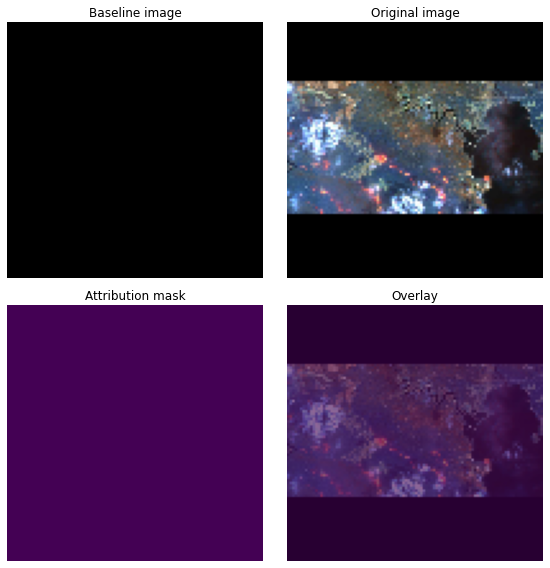

In [ ]:
_ = plot_img_attributions(image=img_name_tensors[14],
                          baseline=baseline,
                          target_class_idx=0,
                          m_steps=240,
                          cmap=plt.cm.viridis,
                          overlay_alpha=0.4)

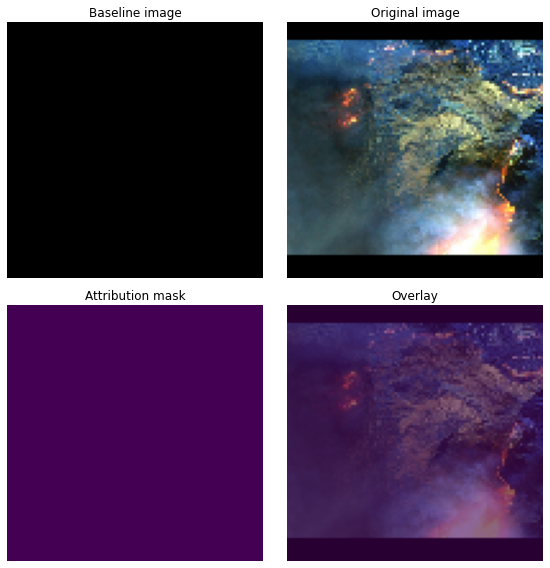

In [ ]:
_ = plot_img_attributions(image=img_name_tensors[21],
                          baseline=baseline,
                          target_class_idx=0,
                          m_steps=240,
                          cmap=plt.cm.viridis,
                          overlay_alpha=0.4)